<a href="https://colab.research.google.com/github/tedteske/PintwoodDerbyStats/blob/main/Pintwood_Derbystats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Pintwood Derby Spring 2022 Results

First, import the libraries we'll need and load the CSV results files into a Pandas dataframe.

In [1]:
#see https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import glob
import os
import pandas as pd
import statsmodels.formula.api as sm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,5)})
plt.rcParams["font.family"] = "serif"

import warnings 
warnings.simplefilter('ignore')

def top_times(df, filter_dict=None, means=True, top=10):
    '''
    Print dataframe of top times.
    
    Parameters
    ----------
    df : dataframe of race data
    filter_dict : dictionary, filter used to narrow results by column values
    means : bool, if True, return mean time, grouped by car
    top : int, number of top times to display
    '''
    if filter_dict:
        df = df[df.isin(filter_dict).sum(1) == len(filter_dict.keys())]
        # adapted from https://stackoverflow.com/questions/38137821
    df = df[['Car', 'Last Name', 'First Name', 'Lane', 'Time']]
    if means:
        aggs = {'Time':['mean','std']}
        df = df.groupby(['Car','Last Name','First Name']).agg(aggs)
        df.columns = ['Time', 'Stdev']
    mu = df['Time'].mean()
    stdev = df['Time'].std()
    df['Z-score'] = (df['Time'] - mu)/stdev
    df = df.sort_values('Time')
    df = df.head(top)
    df = df.reset_index()
    df.index += 1 
    return df

def most_improved(df, year_A, year_B, top=10):
    '''
    Print dataframe of scouts who improved the most between year_A and year_B.
    
    Parameters
    ----------
    df : dataframe of race data
    year_A : text string
    year_B : text string
    top : int, number of top times to display
    '''
    name_columns = ['Last Name','First Name']
    pA_df = top_times(df, {'Year': [year_A]}, means=True, top=None)
    pB_df = top_times(df, {'Year': [year_B]}, means=True, top=None)
    inner_df = pd.merge(left=pA_df, right=pB_df, 
                        left_on=name_columns, right_on=name_columns,
                        suffixes=('_' + year_A, '_' + year_B))
    TimeA_col = 'Time_' + year_A
    TimeB_col = 'Time_' + year_B
    inner_df = inner_df[['Last Name','First Name', TimeB_col, TimeA_col]]
    inner_df['Diff'] = inner_df[TimeB_col] - inner_df[TimeA_col]
    inner_df = inner_df.sort_values('Diff').head(top)
    inner_df = inner_df.reset_index()
    inner_df.index += 1 
    return inner_df

def rookies(df, year):
    '''
    Return dataframe of race data from rookies only.
    
    Parameters
    ----------
    df : dataframe of race data
    year : text string
    '''
    aggs = {'Year':['max','nunique']}
    df0 = df.groupby(['Last Name','First Name']).agg(aggs)
    df0.columns = ['Year', 'Tenure']
    df0 = df0[(df0["Year"]==year) & (df0["Tenure"]==1)]
    df0.drop(['Year', 'Tenure'], axis=1, inplace=True)
    df0.reset_index(inplace=True)
    rookies_df = df.merge(df0, on=['Last Name', 'First Name'])
    return rookies_df

def derby_regression(df, years):
    '''
    Print results of regression of Time on (presumed) factors most 
    influencing it.
    
    Parameters
    ----------
    df : dataframe of race data
    years : list of text strings, years to include in data to be analyzed 
    '''
    df = df[df.Year.isin(years)]

    # assign ages to preliminary heat cohorts
    for i in zip(['Lion', 'Tiger', 'Wolf', 'Bear', 'Webelo', 'AOL'], range(6)):
        df.loc[df['Round']==i[0],'Age'] = i[1]
    df.loc[df['Round']=='LiTiWolf', 'Age'] = 1 #assume the avg is a Tiger
    df.loc[df['Round']=='WebAOL', 'Age'] = 4.5 #middle between Web and AOL
    df.loc[df['Round']=='prelims', 'Age'] = 2.5 #middle between Tiger and AOL
    
    for i in [2,3,4,5,6]: 
        df.loc[df['Lane']==i,'Lane'+str(i)] = 1
    df.loc[df['Last Name']=='Schoonover','Schoonover'] = 1
    for n in ['Age', 'Lane2','Lane3','Lane4','Lane5','Lane6', 'Schoonover']:
        df[n].fillna(0, inplace=True)
    reg_form = "Time ~ Age + Lane2 + Lane3 + Lane4 + Lane5 + Lane6 + Schoonover"
    result = sm.ols(formula=reg_form, data=df).fit()
    print(result.summary())
    return None

def derby_regression_pintwood(df, years):
    '''
    Print results of regression of Time on (presumed) factors most 
    influencing it.
    
    Parameters
    ----------
    df : dataframe of race data
    years : list of text strings, years to include in data to be analyzed 
    '''
    df = df[df.Year.isin(years)]
   
    for i in [2,3,4,5,6]: 
        df.loc[df['Lane']==i,'Lane'+str(i)] = 1
    df.loc[df['Car'].isin([4,5,7,8,13,14,22]),'Pack27'] = 1
    df.loc[df['Round']=='PrelimB','PrelimB'] = 1
    df.loc[df['Round']=='PrelimC','PrelimC'] = 1
    df.loc[df['Round']=='PrelimD','PrelimD'] = 1
    df.loc[df['Round']=='PrelimE','PrelimE'] = 1

    for n in ['Lane2','Lane3','Lane4','Lane5','Lane6', 
              'PrelimB','PrelimC','PrelimD','PrelimE','Pack27']:
        df[n].fillna(0, inplace=True)
    reg_form = "Time ~ Lane2 + Lane3 + Lane4 + Lane5 + Lane6 + \
                PrelimB + PrelimC + PrelimD + PrelimE + Pack27"
    result = sm.ols(formula=reg_form, data=df).fit()
    print(result.summary())
    return None

def compare_hist(df, comps_dict, filter_dict=None, 
                 title=None, hist=True, norm_hist=True, kde=True, fit=None):
    '''
    Plot comparable histograms of race data on the same graph.
    
    Parameters
    ----------
    df : dataframe of race data
    comps_dict : dictionary of keys (field names) and values used as a basis of 
        comparison between plots
    filter_dict : dictionary of keys and values used to filter data used across 
        all plots
    title : text string, title at top of graph
    hist : bool, If True, plot a histogram.
    norm_hist : bool, If True, histogram height is a density, instead of count.
    kde : bool, If True, plot a kernel density estimate.
    fit : "random variable object, optional, An object with fit method, 
        returning a tuple that can be passed to a pdf method a positional 
        arguments following a grid of values to evaluate the pdf on." 
        (from seaborn.distplot)
    '''
    if filter_dict:
        df = df[df.isin(filter_dict).sum(1) == len(filter_dict.keys())]
    plots = len(comps_dict)
    fig, axes = plt.subplots(plots, 1, 
                             figsize=(10, plots * 10/1.6), sharex=True)
    if plots > 1:
        axes = axes.flat
    else:
        axes = [axes]
    for ax, column in zip(axes, comps_dict):
        for value in comps_dict[column]:
            try:
                fseries = df[df[column].isin([value])]['Time']
            except:
                column = column[:-1]
                fseries = df[df[column].isin([value])]['Time']
            sns.distplot(fseries,
                label=value,
                hist=hist,
                norm_hist=norm_hist,
                kde=kde, kde_kws={'fill':False},
                fit=fit,
                bins=None,
                ax=ax, axlabel=False)
            if kde: 
                c = ax.get_lines()[-1].get_c()
                ax.axvline(fseries.mean(), color=c, linestyle='--')
                legend_title = "------  averages" 
            else: 
                legend_title = None
            if norm_hist:
                ax.set(ylabel='relative frequency')
            else: 
                ax.set(ylabel='frequency')
            leg = ax.legend(title=legend_title, title_fontsize='medium')
            leg._legend_box.align = "left"
    axes[-1].set(xlabel='time (sec)')
    if title: 
        fig.suptitle(title)
        fig.subplots_adjust(top=0.93)
    plt.subplots_adjust(hspace=0.07)
    plt.show()
    return None

In [5]:
data_dir = "/content/gdrive/My Drive/Colab Notebooks/scouts/Pintwood Derby"
year_dirs = ["2022"]
col_dict = {"Heat#" : "Heat",
            "Car#" : "Car", 
            "Avg MPH" : "MPH" }
prelims_list = ['PrelimA', 'PrelimB','PrelimC','PrelimD','PrelimE']
finals_list = ['Finals']
disregard_list = []

# Iterate through data directory and import *.csv files into dataframe.
temp_list = []
for year_dir in year_dirs:
    results_files = glob.glob(data_dir + "/" + year_dir + "/" + "*.csv")
    for results_file in results_files:
        df = pd.read_csv(results_file, index_col=None, header=0)
        results_file = os.path.basename(results_file) 
        df['Round'] = results_file.replace('.csv', '')
        df['Year'] = year_dir
        df.rename(columns=col_dict, inplace=True)
        temp_list.append(df)
all_results_df = pd.concat(temp_list, axis = 0, ignore_index = True)
null_times_rows = all_results_df[all_results_df["Time"].isnull()].index
all_results_df = all_results_df.drop(null_times_rows, axis=0)
all_results_df = all_results_df[~all_results_df.Round.isin(disregard_list)]

# Scan for misspelled names and fix.
Names_Fixes = []
for i in Names_Fixes:
    all_results_df.loc[(all_results_df['Last Name'] == i[0]) & 
                        (all_results_df['First Name'] == i[1]),
                    ['Last Name', 'First Name']]=[i[2], i[3]]

prelims_df = all_results_df[all_results_df.Round.isin(prelims_list)]
finals_df = all_results_df[all_results_df.Round.isin(finals_list)]

### Preliminary Rounds

How many cars participated?

In [6]:
prelims_df.groupby(['Year'])['Car'].nunique()

Year
2022    29
Name: Car, dtype: int64

Now, run the usual stats.

In [7]:
prelims_df.groupby(['Year'])['Time'].describe().round(3).T

Year,2022
count,174.000
mean,3.494
std,0.723
min,3.003
25%,3.092
50%,3.242
75%,3.643
max,10.000


Here are the same stats broken down by preliminary round.

In [8]:
prelims_df.groupby(['Year', 'Round'])['Time'].describe().round(3).T

Year     2022                                
Round PrelimA PrelimB PrelimC PrelimD PrelimE
count  36.000  36.000  36.000  36.000  30.000
mean    3.605   3.204   3.492   3.234   4.021
std     1.202   0.118   0.613   0.219   0.597
min     3.025   3.047   3.006   3.003   3.061
25%     3.068   3.133   3.090   3.038   3.641
50%     3.238   3.151   3.236   3.230   4.333
75%     3.752   3.341   3.530   3.267   4.476
max    10.000   3.417   4.960   3.731   5.034

It appears that PrelimB was the fastest round. Test whether the difference is significant or just chance.

In [9]:
stats.ttest_ind(prelims_df[prelims_df.Round.isin(['PrelimB'])]['Time'], 
                prelims_df[prelims_df.Round.isin(['PrelimA'])]['Time'])

Ttest_indResult(statistic=-1.9946266153567596, pvalue=0.04997882554108734)

In [10]:
stats.ttest_ind(prelims_df[prelims_df.Round.isin(['PrelimB'])]['Time'], 
                prelims_df[prelims_df.Round.isin(['PrelimC'])]['Time'])

Ttest_indResult(statistic=-2.7730038359603095, pvalue=0.007112590489607318)

In [11]:
stats.ttest_ind(prelims_df[prelims_df.Round.isin(['PrelimB'])]['Time'], 
                prelims_df[prelims_df.Round.isin(['PrelimE'])]['Time'])

Ttest_indResult(statistic=-8.049157369412878, pvalue=2.6406317268873522e-11)

Since pvalues < 0.05, we *can* reject the null hypothesis that the samples PrelimA, PrelimC, and PrelimE are drawn from the same process as PrelimB. In other words, PrelimB was *significantly* faster than those three. 

In [12]:
stats.ttest_ind(prelims_df[prelims_df.Round.isin(['PrelimB'])]['Time'], 
                prelims_df[prelims_df.Round.isin(['PrelimD'])]['Time'])

Ttest_indResult(statistic=-0.7250982709455613, pvalue=0.47080876760174495)

However, since the above pvalue > 0.05, we *cannot* reject the null hypothesis that the sample PrelimD is drawn from the same process. In other words, PrelimB was not *significantly* faster than PrelimD. Pretty much a tie.

Let's see what the distribution of times looks like by drawing a histogram.

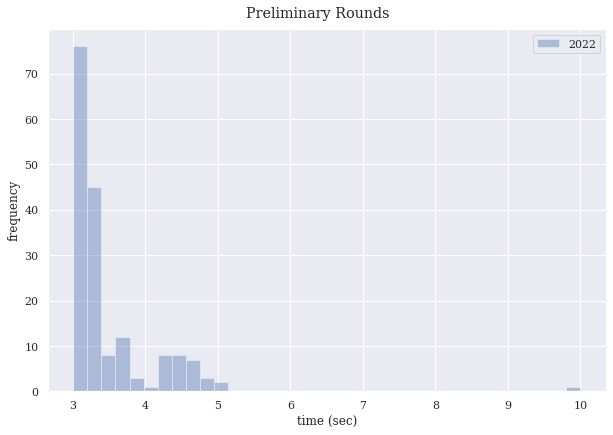

In [13]:
comps = {'Year' : ["2022"]}
compare_hist(prelims_df, comps, title="Preliminary Rounds",
         hist=True, norm_hist=False, kde=False)

Let's normalize and smooth the histogram and add a line representing the average time.

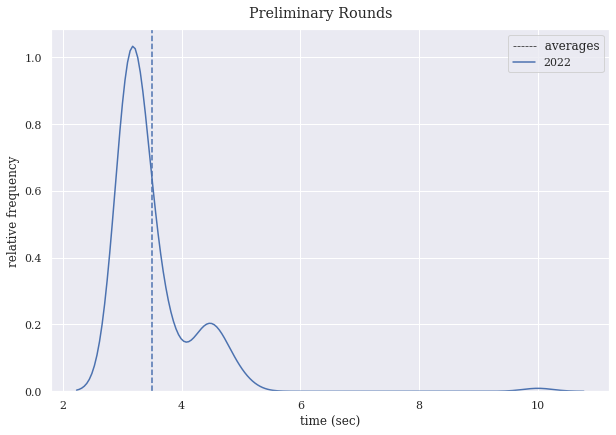

In [14]:
comps = {'Year' : ["2022"]}
compare_hist(prelims_df, comps, title="Preliminary Rounds",
         hist=False, norm_hist=True, kde=True)

There appear to be two groups, those with times centered around 3.5 seconds and those with time centered around 4.5 seconds.

Average Time by car in the prelims, the top 12. Z-score, or standard score, indicates how fast each car was that in terms of standard deviations from the overall average. See https://en.wikipedia.org/wiki/Standard_score for more info.

In [15]:
filter_dict = {'Year' :['2022']}
top_times(prelims_df, filter_dict, means=True, top=12)

,Car,Last Name,First Name,Time,Stdev,Z-score
1,23,Hein,Owen,3.011017,0.006761,-0.785382
2,4,Green,Luke,3.029083,0.005142,-0.755992
3,13,Schoonover,Daniel,3.031633,0.024723,-0.751843
4,24,Melton,Larry,3.047767,0.014450,-0.725598
5,5,Evers,Lindel,3.066517,0.009292,-0.695095
6,26,Martin,Josh,3.079633,0.015445,-0.673757
7,8,Schoonover,Lacey,3.095217,0.099888,-0.648406
8,9,Mitchell,Rick,3.135800,0.005145,-0.582385
9,7,Pool,Jason,3.137250,0.010669,-0.580027
10,10,Tharp,Stephen,3.155983,0.007077,-0.549551


And here are the top 12 individual Times in the prelims.

In [16]:
filter_dict = {'Year' :['2022']}
top_times(prelims_df, filter_dict, means=False, top=12)

,index,Car,Last Name,First Name,Lane,Time,Z-score
1,124,23,Hein,Owen,5,3.0034,-0.678149
2,131,23,Hein,Owen,6,3.0037,-0.677734
3,179,13,Schoonover,Daniel,6,3.0060,-0.674553
4,117,23,Hein,Owen,4,3.0100,-0.669022
5,110,23,Hein,Owen,3,3.0133,-0.664459
6,132,23,Hein,Owen,1,3.0149,-0.662246
7,151,13,Schoonover,Daniel,2,3.0160,-0.660725
8,139,23,Hein,Owen,2,3.0208,-0.654087
9,144,13,Schoonover,Daniel,1,3.0222,-0.652151
10,165,13,Schoonover,Daniel,4,3.0226,-0.651598


### Finals Rounds

How many cars participated?

In [17]:
finals_df.groupby(['Year'])['Car'].nunique()

Year
2022    12
Name: Car, dtype: int64

Now, run the usual stats.

In [18]:
finals_df.groupby(['Year'])['Time'].describe().round(3).T

Year,2022
count,72.000
mean,3.092
std,0.112
min,3.009
25%,3.038
50%,3.064
75%,3.126
max,3.915


And here are the usual stats for those same cars in the prelims.

In [21]:
prelims_df[prelims_df.Car.isin(finals_df['Car'])].groupby(['Year'])['Time'].describe().round(3).T

Year,2022
count,66.000
mean,3.103
std,0.111
min,3.003
25%,3.037
50%,3.072
75%,3.142
max,3.803


It appears that the cars were faster in the finals than they were in the prelims. Test whether the difference is significant or just chance.

In [22]:
stats.ttest_ind(finals_df['Time'],
                prelims_df[prelims_df.Car.isin(finals_df['Car'])]['Time'])

Ttest_indResult(statistic=-0.5651952961360159, pvalue=0.5728721200115736)

Since the pvalue>0.05, we cannot reject the null hypothesis that the samples are drawn from the same process. In other words, the finals were not significantly faster those same cars were in the prelims.

Average Time by car in the finals.

In [23]:
filter_dict = {'Year' :['2022']}
top_times(finals_df, filter_dict, means=True, top=12)

,Car,Last Name,First Name,Time,Stdev,Z-score
1,4,Green,Luke,3.015100,0.004086,-1.178745
2,13,Schoonover,Daniel,3.025350,0.018700,-1.021318
3,23,Hein,Owen,3.031583,0.008968,-0.925581
4,24,Melton,Larry,3.042767,0.012345,-0.753819
5,5,Evers,Lindel,3.061317,0.005558,-0.468913
6,26,Martin,Josh,3.068550,0.030027,-0.357817
7,8,Schoonover,Lacey,3.087167,0.068929,-0.071888
8,10,Tharp,Stephen,3.108717,0.008745,0.259094
9,9,Mitchell,Rick,3.131117,0.009132,0.603132
10,7,Pool,Jason,3.140817,0.026068,0.752112


And here are the top 12 individual Times in the finals.

In [24]:
filter_dict = {'Year' :['2022']}
top_times(finals_df, filter_dict, means=False, top=12)

,index,Car,Last Name,First Name,Lane,Time,Z-score
1,71,4,Green,Luke,6,3.0087,-0.744176
2,61,4,Green,Luke,2,3.0117,-0.717326
3,65,26,Martin,Josh,6,3.0121,-0.713746
4,64,13,Schoonover,Daniel,5,3.0121,-0.713746
5,42,13,Schoonover,Daniel,1,3.0132,-0.703901
6,31,13,Schoonover,Daniel,2,3.0144,-0.693160
7,41,13,Schoonover,Daniel,6,3.0154,-0.684210
8,22,4,Green,Luke,5,3.0156,-0.682420
9,54,23,Hein,Owen,1,3.0160,-0.678840
10,0,4,Green,Luke,1,3.0171,-0.668995


### Lanes, Ages and the Schoonover Effect

Are there any differences among the lanes? First run the usual stats and plot the distributions.

In [25]:
lanes_df = prelims_df[prelims_df.Year.isin(['2022'])][['Lane','Time']]
lanes_df.groupby(['Lane']).describe().round(4).T

Lane              1        2        3        4        5        6
Time count  29.0000  29.0000  29.0000  29.0000  29.0000  29.0000
     mean    3.4908   3.4790   3.4560   3.4525   3.6345   3.4500
     std     0.5905   0.5472   0.4853   0.5084   1.3238   0.5570
     min     3.0149   3.0160   3.0133   3.0100   3.0034   3.0037
     25%     3.0773   3.0996   3.1309   3.1224   3.0906   3.0949
     50%     3.2301   3.2628   3.2645   3.2319   3.2405   3.2299
     75%     3.6444   3.6985   3.7000   3.6396   3.4126   3.3820
     max     5.0341   4.8171   4.6217   4.7000   9.9999   4.9025

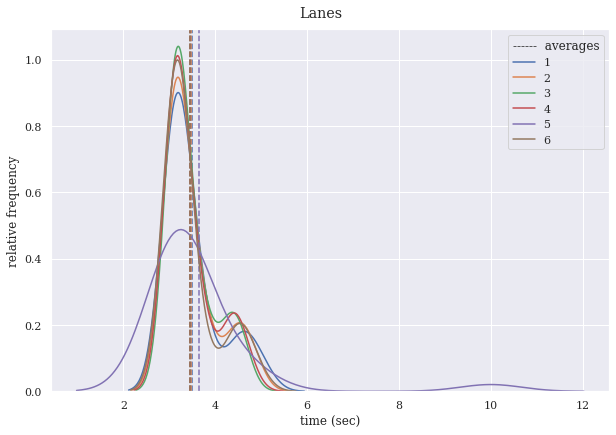

In [26]:
comps = {'Lane' : [1,2,3,4,5,6]}
compare_hist(lanes_df, comps, title="Lanes",
         hist=False, norm_hist=True, kde=True)

It looks like lane 5 is a slower and more spread out than the others. Do we see this when comparing the lane results of the fastest car?

In [27]:
filter_dict = {'Year' :['2022'], 'Car':[23]}
top_times(prelims_df, filter_dict, means=False)

,index,Car,Last Name,First Name,Lane,Time,Z-score
1,124,23,Hein,Owen,5,3.0034,-1.126479
2,131,23,Hein,Owen,6,3.0037,-1.082110
3,117,23,Hein,Owen,4,3.0100,-0.150361
4,110,23,Hein,Owen,3,3.0133,0.337697
5,132,23,Hein,Owen,1,3.0149,0.574332
6,139,23,Hein,Owen,2,3.0208,1.446921


Next, run a test between each pair of lanes to determine if the lane means are significantly different.

In [28]:
lanes = [1,2,3,4,5,6]

b = [[i, j] for i in lanes for j in lanes]
combos = []
for i in b:
    if i[0]<i[1]: 
        combos.append(i)

pvalues = []
for i in combos:
    e = lanes_df["Time"][lanes_df["Lane"]==i[0]]
    f = lanes_df["Time"][lanes_df["Lane"]==i[1]]
    pvalue = round(stats.ttest_ind(e, f)[1],4)
    pvalues.append(pvalue)

pd.DataFrame({'Lane Pair': combos,
              'P-value' : pvalues}).sort_values('P-value')


,Lane Pair,P-value
14,"[5, 6]",0.4918
12,"[4, 5]",0.4923
10,"[3, 5]",0.4981
7,"[2, 5]",0.5610
3,"[1, 5]",0.5954
4,"[1, 6]",0.7875
2,"[1, 4]",0.7923
1,"[1, 3]",0.8071
8,"[2, 6]",0.8422
6,"[2, 4]",0.8494


Since, for each pair of lanes, the probability is high (p-value>0.05) that the mean Time difference is chance, we can conclude there is no significant difference among the lanes' mean Times. Please note that the significance level we choose (0.05) implies a confidence level of of 95%, and that it's just a convention. 

#### The Pack 27 Effect

Yes, there is one, and it's measurable and significant. On average and when controlling for rounds and lanes, being an adult leader at Pack 27 reduces the Time by around 0.44 seconds (Pass it on!). See the coefficient for `Pack27` in the results below.

In [73]:
derby_regression_pintwood(prelims_df, ['2022'])

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     4.794
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           4.92e-06
Time:                        22:10:05   Log-Likelihood:                -167.56
No. Observations:                 174   AIC:                             357.1
Df Residuals:                     163   BIC:                             391.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7485      0.161     23.301      0.0

### Distributional Analysis and Fastest Possible Time

Let's look again at the histogram for the preliminary rounds.

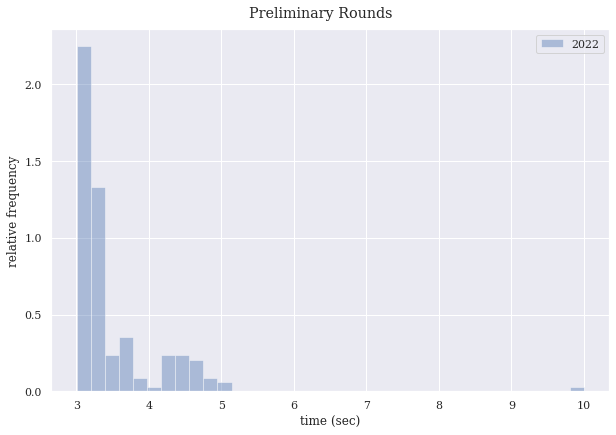

In [29]:
comps = {'Year' : ['2022']}
compare_hist(prelims_df, comps, title="Preliminary Rounds",
         hist=True, norm_hist=True, kde=False)

Can we say with confidence that the preliminaries' times are normally distributed (i.e. follow a bell curve)? Do a test for normality.

In [30]:
times = prelims_df[prelims_df.Year.isin(['2022'])]['Time']
stats.normaltest(times)

NormaltestResult(statistic=209.99583043170017, pvalue=2.5117985790101577e-46)

Since the above p-value < 0.05 , we can reject the null hypothesis that Times are distributed normally. 

The histogram appears to have a long right tail and a hard boundary on the left. Perhaps a lognormal distribution is more appropriate. Superimpose a lognormal probability density function to the histogram and check visually for goodness of fit.

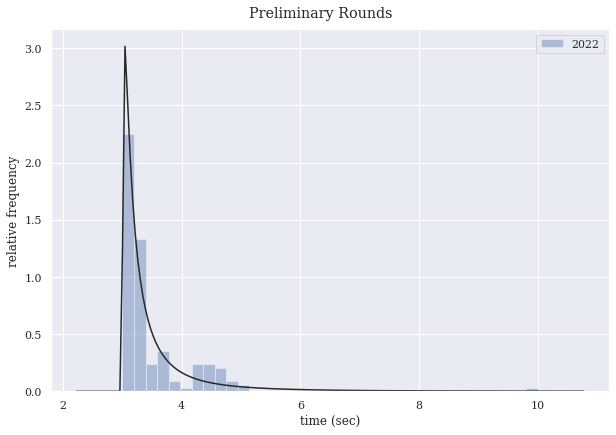

In [31]:
comps = {'Year' : ['2022']}
compare_hist(prelims_df, comps, title="Preliminary Rounds",
             hist=True, norm_hist=True, kde=False, fit=stats.lognorm)

The curve looks to fit the data well. In others words, the data appear to follow a lognormal distribution. Test for goodness of fit.

In [32]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest
stats.kstest(times, "lognorm", stats.lognorm.fit(times))

KstestResult(statistic=0.07151377639824663, pvalue=0.32172122767772754)

Since the above p-value > 0.05 , we cannot reject the null hypothesis that Times follow a lognormal distribution. Also, we know that simulating the track physics yields a lognormal distribution of race times. See https://github.com/tedteske/DerbySim/blob/master/DerbySim.ipynb for details.

Now, estimate the parameters of that distribution, and plot a historgram of random draws from it to see if it resembles the original data. 

shape =  1.2989
lower bound =  2.9955
distance from lower bound to median =  0.2352




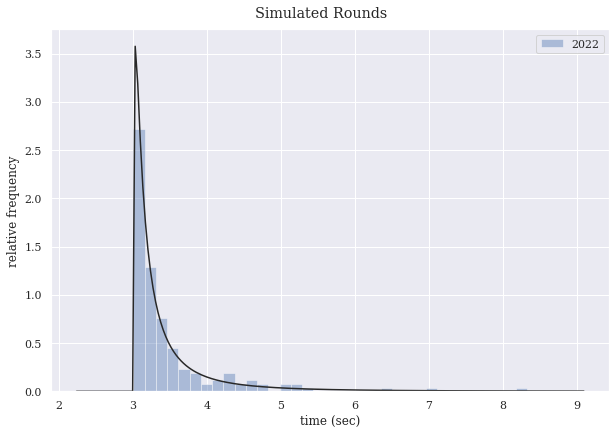

In [33]:
shape, floor, median = stats.lognorm.fit(times)

print("shape = ", shape.round(4))
print("lower bound = ", floor.round(4))
print("distance from lower bound to median = ", median.round(4))
print("\n")

dist = []
for i in range(len(times)):
    x = stats.lognorm.rvs(s=shape, loc=floor, scale=median)
    dist.append(['2022', x])

df = pd.DataFrame(dist, columns = ['Year', 'Time'])  

comps = {'Year' : ['2022']}
compare_hist(df, comps_dict=comps, title="Simulated Rounds",
         hist=True, norm_hist=True, kde=False, fit=stats.lognorm)

Yes, sure does. 

If this curve then is representative, then what is the probability that some car randomly selected from this group runs a time better than 3.2 seconds?

In [29]:
#https://matthew-brett.github.io/teaching/on_cdfs.html
stats.lognorm.cdf(x=3.2, s=shape, loc=floor, scale=median).round(4)

0.4571

...and better than 3.1 seconds?

In [75]:
stats.lognorm.cdf(x=3.1, s=shape, loc=floor, scale=median).round(4)

0.2662

...which is consistent with the lower bound of the distribution above.  Note that this is seems to run coutner to with the fastest possible time (with stock wheels and one wheel lifted) of 3.0378. 

See again https://github.com/tedteske/DerbySim/blob/master/DerbySim.ipynb for details.